In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
cd /content/gdrive/My Drive/Colab Notebooks

/content/gdrive/My Drive/Colab Notebooks


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from keras import backend as K
% matplotlib inline

# Keras imports
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, Sequential
from keras.metrics import categorical_accuracy, binary_accuracy
from keras.optimizers import Adam, SGD, Nadam
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.layers import concatenate

# imports from files
from src.metrics import dice_coef, jacc_coef, jacc_loss, dice_loss
from src.preprocessing import build_matrix_preprocess, build_matrix_mask
from src.models import get_unet, u_net, u_net_normalized

Using TensorFlow backend.


# Preprocessing

In [0]:
# initialization
nb_training_images = 700
nb_validation_images = 200
nb_test_images = 100

# Resize image dimension
img_rows, img_cols = 128, 128

In [0]:
# train data is stored in train.csv
df = pd.read_csv('./data/train.csv')
X_df = df['ImageId']
X = X_df.values

# test and validation data are stored in test.svc
df_submission = pd.read_csv('./data/test.csv')
test = df_submission['ImageId'].values

In [6]:
# process and import train images and corresponding masks
imgs_train = build_matrix_preprocess(X)
imgs_mask_train = build_matrix_mask(X)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [7]:
# process and import valdiation and test images and corresponding masks
imgs_test = build_matrix_preprocess(test)
imgs_mask_test = build_matrix_mask(test)
# NB : The above functions take time to compute the matrices

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [0]:
# reshape size to add extra dimension
imgs_mask_train = imgs_mask_train.reshape(nb_training_images, img_rows, img_cols, 1)
imgs_mask_test = imgs_mask_test.reshape(nb_validation_images + nb_test_images, img_rows, img_cols, 1)

In [0]:
# Assign train, validation and test image and mask based on training dataset 
x_train = imgs_train
y_train = imgs_mask_train

x_val = imgs_test[:nb_validation_images]
y_val = imgs_mask_test[:nb_validation_images]

x_test = imgs_test[nb_validation_images:]
y_test = imgs_mask_test[nb_validation_images:]

# Settings

In [10]:
# Model parameters
model_name = "model1"
seed = 1
nb_epoch = 10
batch_size = 32
loss_param = 'dice'
optimizer_param = 'adam'
monitor_metric = 'val_jacc_coef'
metrics = [jacc_coef]

# Loss options    
loss_options = {'BCE': 'binary_crossentropy', 'dice':dice_loss, 'jacc':jacc_loss}
loss = loss_options['dice']

# Optimizer options
optimizer_options = {'adam': Adam(lr=0.002),
                     'sgd': SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)}
optimizer = optimizer_options['adam']

# Specify model filename
model_filename = "u_net.h5"

Instructions for updating:
Colocations handled automatically by placer.


# Callbacks

In [0]:
from keras.callbacks import ModelCheckpoint
checkpoint_path="./u_netbacthn.hdf5"
checkpoint = ModelCheckpoint(checkpoint_path, monitor= monitor_metric, verbose=1, save_best_only=True, mode='max')
save_best_only = [checkpoint]

#Data generator

In [0]:
def myGenerator(train_generator, train_mask_generator):
    while True:
        train_gen = next(train_generator)
        train_mask = next(train_mask_generator)
        yield (train_gen, train_mask)

In [0]:
# Define dictionary for data augmentation
data_gen_args = dict(featurewise_center = False, 
                         featurewise_std_normalization = True, 
                         samplewise_std_normalization = True, 
                         zca_whitening = False, 
                         rotation_range = 270, 
                         width_shift_range = 0.1, 
                         height_shift_range = 0.1, 
                         horizontal_flip = False, 
                         vertical_flip = False, 
                         zoom_range = 0.2,
                         channel_shift_range = 0,
                         fill_mode = 'reflect',
                         dim_ordering = K.image_dim_ordering())
data_gen_mask_args = dict(list(data_gen_args.items()) + list({'fill_mode':'nearest','samplewise_center':False}.items()))

In [0]:
# Perform data augmentation using Keras ImageDataGenerator
print("Create Data Generator")
train_datagen = ImageDataGenerator(data_gen_args)
train_datagen.fit(x_train)
train_mask_datagen = ImageDataGenerator(data_gen_mask_args)
train_mask_datagen.fit(y_train)
train_generator = train_datagen.flow(x_train, batch_size=batch_size, seed=seed)
train_mask_generator = train_mask_datagen.flow(y_train, batch_size=batch_size, seed=seed)
train_generator_f = myGenerator(train_generator, train_mask_generator)

Create Data Generator


#Specify network architecture for training


### U-net with batch normalization

In [0]:
def u_net_normalized(img_rows, img_cols, loss , optimizer, metrics):
    
    # Convolution Layers (BatchNorm after non-linear activation)
  
    img_input = Input((img_rows, img_cols,3))
    x = Conv2D(16, (3, 3), padding='same', name='conv1')(img_input)
    x = BatchNormalization(name='bn1')(x)
    x = Activation('relu')(x)
    x = Conv2D(32, (3, 3), padding='same', name='conv2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
    x = Conv2D(64, (3, 3), padding='same', name='conv3')(x)
    x = BatchNormalization(name='bn3')(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same', name='conv4')(x)
    x = BatchNormalization(name='bn4')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
    x = Conv2D(128, (3, 3), padding='same', name='conv5')(x)
    x = BatchNormalization(name='bn5')(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (4, 4), padding='same', name='conv6')(x)
    x = BatchNormalization(name='bn6')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
    x = Conv2D(256, (3, 3), padding='same', name='conv7')(x)
    x = BatchNormalization(name='bn7')(x)
    x = Dropout(0.5)(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='conv8')(x)
    x = BatchNormalization(name='bn8')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv9')(x)
    x = BatchNormalization(name='bn9')(x)
    x = Activation('relu')(x)
    x = Dense(1024, activation = 'relu', name='fc1')(x)
    x = Dense(1024, activation = 'relu', name='fc2')(x)
  
  # Deconvolution Layers (BatchNorm after non-linear activation)
  
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv1')(x)
    x = BatchNormalization(name='bn19')(x)
    x = Activation('relu')(x)
    x = UpSampling2D()(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv2')(x)
    x = BatchNormalization(name='bn12')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv3')(x)
    x = BatchNormalization(name='bn13')(x)
    x = Activation('relu')(x)
    x = UpSampling2D()(x)
    x = Conv2DTranspose(128, (4, 4), padding='same', name='deconv4')(x)
    x = BatchNormalization(name='bn14')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv5')(x)
    x = BatchNormalization(name='bn15')(x)
    x = Activation('relu')(x)
    x = UpSampling2D()(x)
    x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv6')(x)
    x = BatchNormalization(name='bn16')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(32, (3, 3), padding='same', name='deconv7')(x)
    x = BatchNormalization(name='bn20')(x)
    x = Activation('relu')(x)
    x = UpSampling2D()(x)
    x = Conv2DTranspose(16, (3, 3), padding='same', name='deconv8')(x)
    x = BatchNormalization(name='bn17')(x)
    x = Dropout(0.5)(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(1, (3, 3), padding='same', name='deconv9')(x)
    x = BatchNormalization(name='bn18')(x)
    x = Activation('sigmoid')(x)
    
    pred = Reshape((img_rows,img_cols,1))(x)
  
    model = Model(inputs=img_input, outputs=pred)
    
    #model.load_weights('./u_net.hdf5')
  
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)  
  
    return model

### u_net

In [0]:
def get_unet(img_rows, img_cols, loss , optimizer, metrics):

    inputs = Input((img_rows, img_cols, 3))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

  
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)  
  
    
    return model

### U-net2 

In [0]:
def u_net2(img_rows, img_cols, loss , optimizer, metrics):
    
    img_input = Input((img_rows, img_cols,3))
    x = Conv2D(16, (3, 3), padding='same', name='conv1')(img_input)
    x = Activation('relu')(x)
    x = Conv2D(32, (3, 3), padding='same', name='conv2')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
    x = Conv2D(64, (3, 3), padding='same', name='conv3')(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same', name='conv4')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
    x = Conv2D(128, (3, 3), padding='same', name='conv5')(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (4, 4), padding='same', name='conv6')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
    x = Conv2D(256, (3, 3), padding='same', name='conv7')(x)
    x = Dropout(0.5)(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='conv8')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv9')(x)
    x = Activation('relu')(x)
    x = Dense(1024, activation = 'relu', name='fc1')(x)
    x = Dense(1024, activation = 'relu', name='fc2')(x)
  
  # Deconvolution Layers (BatchNorm after non-linear activation)
  
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv1')(x)
    x = Activation('relu')(x)
    x = UpSampling2D()(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv2')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv3')(x)
    x = Activation('relu')(x)
    x = UpSampling2D()(x)
    x = Conv2DTranspose(128, (4, 4), padding='same', name='deconv4')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv5')(x)
    x = Activation('relu')(x)
    x = UpSampling2D()(x)
    x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv6')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(32, (3, 3), padding='same', name='deconv7')(x)
    x = Activation('relu')(x)
    x = UpSampling2D()(x)
    x = Conv2DTranspose(16, (3, 3), padding='same', name='deconv8')(x)
    x = Dropout(0.5)(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(1, (3, 3), padding='same', name='deconv9')(x)
    x = Activation('sigmoid')(x)
    pred = Reshape((128,128,1))(x)
    model = Model(inputs=img_input, outputs=pred)
  
    model = Model(inputs=img_input, outputs=pred)
  
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)  
  


#Useful functions

In [0]:
def save_model(path):
    # serialize model to JSON
    model_json = model.to_json()
    with open(path'.json', "w") as json_file:
    json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(path+'.h5')
    print("Saved model to disk")

In [0]:
def load_model(path):
    from keras.models import load_model
    from keras.models import model_from_json
    # load json and create model
    json_file = open(path+'.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(path+'.h5")
    print("Loaded model from disk")
    loaded_model.compile(optimizer=optimizer, loss=loss, metrics=metrics) 
    return loaded_model

In [0]:
def plot(history):
    # Retrieve a list of accuracy results on training and test data
    # sets for each training epoch
    acc = history.history['jacc_coef']
    val_acc = history.history['val_jacc_coef']

    # Retrieve a list of list results on training and test data
    # sets for each training epoch
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get number of epochs
    epochs = range(len(acc))

    # Plot training and validation accuracy per epoch
    plt.subplot(1,2,1)
    plt.plot(epochs, acc, label = "training")
    plt.plot(epochs, val_acc, label = "validation")
    plt.legend(loc="upper left")
    plt.title('Training and validation jaccard')

    
    plt.subplot(1,2,2)
    # Plot training and validation loss per epoch
    plt.plot(epochs, loss, label = "training")
    plt.plot(epochs, val_loss, label = "validation")
    plt.legend(loc="upper right")
    plt.title('Training and validation loss')

# Train

In [0]:
from keras.models import Model, Sequential
from keras.layers import GlobalAveragePooling2D, BatchNormalization,core , Conv2DTranspose, AveragePooling2D
from keras.layers import Flatten, Dense, Input, Dropout, Activation, Reshape
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, UpSampling2D
from keras.layers import concatenate

In [0]:
u_net = u_net_normalized(img_rows, img_cols, loss , optimizer, metrics)

In [23]:
history = loaded_model.fit(x_train,y_train, batch_size=batch_size,
                             nb_epoch= 5, 
                             validation_data=(x_val,y_val),
                             verbose = 1, callbacks = save_best_only )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  after removing the cwd from sys.path.


Train on 700 samples, validate on 200 samples
Epoch 1/5
700/700 [==============================] - 362s 517ms/step - loss: -0.7864 - jacc_coef: 0.7388 - val_loss: -0.6746 - val_jacc_coef: 0.5992

Epoch 00001: val_jacc_coef did not improve from 0.68214
Epoch 2/5
700/700 [==============================] - 362s 518ms/step - loss: -0.7777 - jacc_coef: 0.7179 - val_loss: -0.7428 - val_jacc_coef: 0.6841

Epoch 00002: val_jacc_coef improved from 0.68214 to 0.68407, saving model to ./u_netbacthn.hdf5
Epoch 3/5
700/700 [==============================] - 356s 509ms/step - loss: -0.8015 - jacc_coef: 0.7472 - val_loss: -0.7618 - val_jacc_coef: 0.6983

Epoch 00003: val_jacc_coef improved from 0.68407 to 0.69831, saving model to ./u_netbacthn.hdf5
Epoch 4/5
700/700 [==============================] - 372s 531ms/step - loss: -0.8145 - jacc_coef: 0.7619 - val_loss: -0.7309 - val_jacc_coef: 0.6635

Epoch 00004: val_jacc_coef did not improve from 0.69831
Epoch 5/5
700/700 [==============================]

# Test

Text(0.5, 1.0, 'Ground Turth')

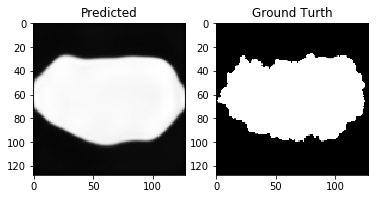

In [57]:
# Show predicted mask and the ground truth
index = 15
predict_input = x_test[index]
ground_truth = y_test[index].reshape(128,128)
predictions =loaded_model.predict(predict_input.reshape(1,128,128,3), batch_size=1)
prediction = predictions.reshape(128, 128)
plt.subplot(1,2,1)
plt.imshow(prediction,cmap='gray')
plt.title('Predicted')
plt.subplot(1,2,2)
plt.imshow(ground_truth,cmap='gray')
plt.title('Ground Turth')

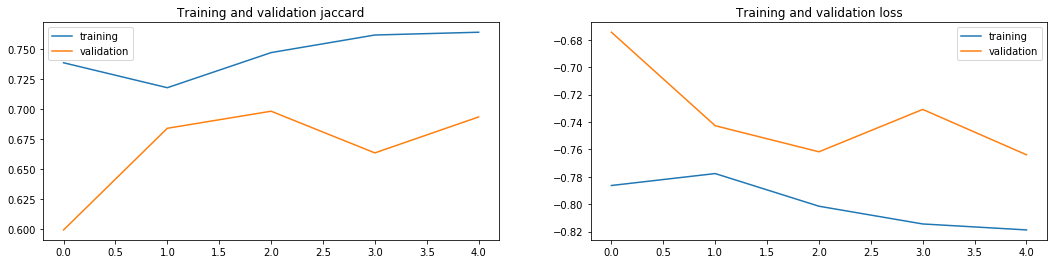

In [67]:
plt.rcParams['figure.figsize'] = (18, 4)
plot(history)

In [0]:
import cv2

Text(0.5, 1.0, 'preprocessed image')

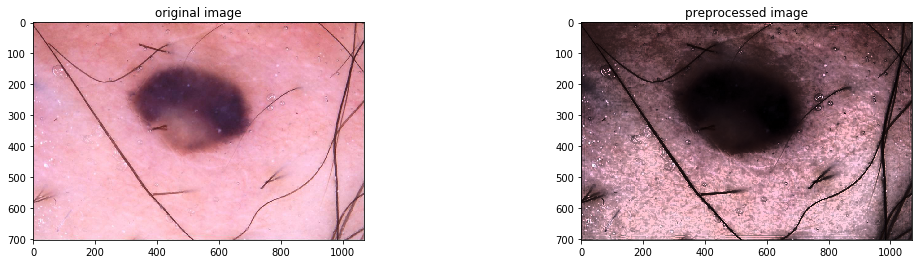

In [82]:
image = X[12]
im = plt.imread('./data/im/'  + str(image) + '.jpg')
hsv = cv2.cvtColor(im,cv2.COLOR_BGR2HSV)
equ = cv2.equalizeHist(hsv[:,:,2])
hsv[:,:,2] = equ
rgb = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)

plt.subplot(1,2,1)
plt.imshow(im)
plt.title('original image')
plt.subplot(1,2,2)
plt.imshow(rgb)
plt.title('preprocessed image')
